In this notebook the greenhouse data on Resorcinol (RE), Catechol (CAT or CA), Tropic acid (TA) and Hydroquinone (HY) will be analysed.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.optimize as opt

Definition of global variables

In [2]:
DATA_DIR = "TA+DHB.csv" # original data in "/Users/David_Sauer/Documents/Data/Greenhouse_countings/january-february/plants.csv"
HEADERS = ["experiment", "solution", "plant", "internal_reproduction", "usable", "total_seeds", "germination_1", "germination_2", "biomass", "notes", "external_reproduction"]
SUBSTANCES = ["Catechol", "Resorcinol", "Hydrochinon", "Tropasäure"]
SUBSTANCES_SHORT = ["C", "R", "H", "TA"]
EXPERIMENT_NAMES = ["CATL1", "CATL2", "CATL3", "REL1", "REL2", "REL3", "HYL1", "HYL2", "HYL3", "TAL1", "TAL2", "TAL3"]

Now we read in the data.

In [3]:
df = pd.read_csv(DATA_DIR, names=HEADERS, sep=";")

In [4]:
df

,experiment,solution,plant,internal_reproduction,usable,total_seeds,germination_1,germination_2,biomass,notes,external_reproduction
0,CATL1,10,le,1,1,28,0,8,0,NaN,1
1,CATL1,10,le,2,1,39,0,24,0,NaN,1
2,CATL1,30,le,1,1,28,0,10,0,NaN,1
3,CATL1,30,le,2,1,24,0,11,0,NaN,1
4,CATL1,50,le,1,1,26,0,9,0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
163,TAL3,40,le,2,1,19,2,16,0,NaN,3
164,TAL3,50,le,1,1,29,1,20,0,NaN,3
165,TAL3,50,le,2,1,47,0,14,0,NaN,3
166,TAL3,CTRL,le,1,1,30,0,18,0,NaN,3


We then define some utility functions.

In [5]:
def hill(c, half, n): 
    return 1/(1+(c/half)**n)

def rmse(predictions, targets):
    return np.sqrt(sum((np.array(predictions) - np.array(targets)) ** 2))

def r2(predictions, targets):
    ssre = sum([n**2 for n in np.array(targets)-np.array(predictions)])
    sstot = sum([n**2 for n in np.array(targets)-np.mean(targets)])
    return 1-(ssre/sstot)

def effects_of_df(df):
    return df["germination_2"]/df["total_seeds"]

def confidence_interval(arr):
    return stats.t.interval(0.95, len(arr)-1, loc=np.mean(arr), scale=stats.sem(arr))


def fit_to_hill(df, substance_idx):
    experiment_names = EXPERIMENT_NAMES[substance_idx*3:(substance_idx+1)*3]
    df = df.loc[df["experiment"].isin(experiment_names) & df["solution"].map(lambda name: name!="CTRL")]
    concentrations = [float(n) for n in df["solution"]]
    effects = effects_of_df(df)
    params, pcov = opt.curve_fit(hill, concentrations, effects, p0=(max(concentrations)/2,1))
    return (params, pcov) #latter is SE for parameters

Now we perform the plotting.

<ipython-input-5-ef22b56942ae>:2: RuntimeWarning: invalid value encountered in power
  return 1/(1+(c/half)**n)


RMSE: 0.1613840764512235
Catechol: D0:27.30±3.45, n:1.43±0.23
RMSE: 0.20220327554078812
Resorcinol: D0:54.83±6.61, n:1.42±0.33
RMSE: 0.23850272934383734
Hydrochinon: D0:71.57±9.56, n:1.50±0.44
RMSE: 0.26013533005000233
Tropasäure: D0:98.96±88.28, n:0.53±0.31


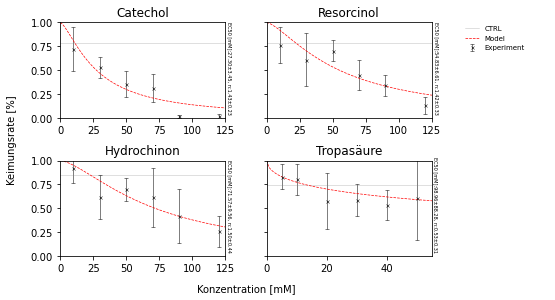

In [7]:
fig, axs = plt.subplots(2,2, squeeze=True, sharey=True)
ctrls=[]
for idx, ax in enumerate(axs.flatten()):
    ec50_estimate = 80
    max_val = 125
    text_offset = 1.2
    if idx==3:
        ec50_estimate = 40
        max_val = 55
        text_offset = 0.5
    local_df = df.loc[df["experiment"].isin(EXPERIMENT_NAMES[idx*3:(idx+1)*3])]
    local_control = local_df.loc[local_df["solution"] == "CTRL"]
    control_germ_percentage = np.mean(local_control["germination_2"])/np.mean(local_control["total_seeds"])
    local_data = local_df.loc[local_df["solution"] != "CTRL"]
    concs = local_data["solution"].unique()
    true_concs = [int(n) for n in local_data["solution"]]
    effects = []
    true_effects = [row["germination_2"]/row["total_seeds"] for index, row in local_data.iterrows()]
    errors = []
    for conc in concs:
        conc_data =local_data.loc[local_data["solution"] == conc]
        local_effects = conc_data["germination_2"]/conc_data["total_seeds"]
        effect = np.mean(conc_data["germination_2"])/np.mean(conc_data["total_seeds"])
        errors.append(np.std(local_effects))
        effects.append(effect)
    concs = [int(n) for n in concs]
    params, pcov = opt.curve_fit(hill, true_concs, true_effects, p0=(ec50_estimate,1))
    ax.plot([0,max_val],[control_germ_percentage, control_germ_percentage], color="grey", linewidth=0.5, alpha=0.5, label="CTRL")
    ax.plot(np.linspace(0,ec50_estimate*2, num=100), [hill(n, params[0], params[1]) for n in np.linspace(0,ec50_estimate*2, num=100)], "--r", linewidth=0.7, label="Model")
    ax.errorbar(concs, effects, yerr=errors, linestyle='None', marker="x", color="k", elinewidth=0.5, capsize=2, markersize=3, mew=0.5, label="Experiment")
    ax.set_title(SUBSTANCES[idx])
    ax.set_xlim([0, max_val])
    ax.set_ylim([0,1])
    pcov = np.sqrt(np.diag(pcov))
    ctrls.append(control_germ_percentage)
    ax.text(max_val+text_offset, 0.05, "EC50 [mM]:{:03.2f}±{:03.2f}, n:{:03.2f}±{:03.2f}".format(params[0],pcov[0],params[1],pcov[1]), rotation=-90, fontsize=5)
    print("RMSE: {}".format(mean_squared_error(true_effects, hill(true_concs, *params), squared=False)))
    print("{}: D0:{:03.2f}±{:03.2f}, n:{:03.2f}±{:03.2f}".format(SUBSTANCES[idx], params[0],pcov[0],params[1],pcov[1]))
    if idx==3:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc=1, bbox_to_anchor=(1.23, 0.975), fontsize=7, frameon=False, shadow=False)
plt.tight_layout()

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.45)
plt.xlabel("Konzentration [mM]", labelpad=10)
plt.ylabel("Keimungsrate [%]", labelpad=20)
fig.savefig("figure.png", dpi=600, bbox_inches='tight')